In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load LOB data

In [2]:
import os
import time
from dataclasses import dataclass

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tqdm.notebook import tqdm
from typing import Tuple, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

In [3]:
@dataclass
class GANConfig:
    name: str = "Baseline"
    batch_size: int = 64
    z_dim: int = 100
    lob_dim: int = 40
    epochs: int = 30
    learning_rate_d: float = 1e-5
    learning_rate_g: float = 0.0002
    beta1: float = 0.5
    beta2: float = 0.999
    label_smoothing: float = 0.0
    # use_vbn: bool = False
    use_historical_avg: bool = False
    historical_averaging_weight: float = 0.0001
    generator_target_prob: float = 1.0
    n_critic: int = 5

config = GANConfig()

In [4]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Using GPU: {gpus}")
else:
    print("Using CPU")

# Load and preprocess LOB data
file_path = "/content/drive/MyDrive/DSA5204/crypto_sample_data/BTCUSDT-lob.parq"
df = pd.read_parquet(file_path, engine="pyarrow")

lob_features = [
    "b0p", "b1p", "b2p", "b3p", "b4p", "b5p", "b6p", "b7p", "b8p", "b9p",
    "b0q", "b1q", "b2q", "b3q", "b4q", "b5q", "b6q", "b7q", "b8q", "b9q",
    "a0p", "a1p", "a2p", "a3p", "a4p", "a5p", "a6p", "a7p", "a8p", "a9p",
    "a0q", "a1q", "a2q", "a3q", "a4q", "a5q", "a6q", "a7q", "a8q", "a9q"
]

df = df.dropna(subset=lob_features).sample(n=1000)
scaler = MinMaxScaler()
lob_data = scaler.fit_transform(df[lob_features].values).astype(np.float32)

lob_dataset = tf.data.Dataset.from_tensor_slices(lob_data).batch(config.batch_size)

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Generator and Discriminator Network

In [5]:
class Generator(models.Model):
    def __init__(self, config):
        super(Generator, self).__init__()
        self.config = config
        self.z_dim = config.z_dim

        self.dense1 = layers.Dense(512, activation=layers.LeakyReLU(0.2))
        self.bn1 = layers.BatchNormalization()
        self.dense2 = layers.Dense(256, activation=layers.LeakyReLU(0.2))
        self.bn2 = layers.BatchNormalization()
        self.dense3 = layers.Dense(128, activation=layers.LeakyReLU(0.2))
        self.output_layer = layers.Dense(40, activation='tanh')

    def constraints(self, lob_output):
        penalties = tf.zeros_like(lob_output)

        penalties += tf.nn.softplus(-lob_output) * 0.1

        bid_prices = lob_output[:, :10]
        bid_diff = bid_prices[:, 1:] - bid_prices[:, :-1]
        bid_penalties = tf.nn.softplus(bid_diff) * 0.5

        batch_size = tf.shape(bid_prices)[0]
        j_indices = tf.range(9, dtype=tf.int32)
        i_indices = tf.range(batch_size, dtype=tf.int32)
        ii, jj = tf.meshgrid(i_indices, j_indices, indexing="ij")
        bid_indices = tf.stack([ii, jj], axis=-1)

        bid_indices = tf.reshape(bid_indices, [-1, 2])
        bid_penalties = tf.reshape(bid_penalties, [-1])

        penalties = tf.tensor_scatter_nd_add(
            penalties,
            bid_indices,
            bid_penalties
        )

        ask_prices = lob_output[:, 20:30]
        ask_diff = ask_prices[:, 1:] - ask_prices[:, :-1]
        ask_penalties = tf.nn.softplus(-ask_diff) * 0.5

        jj_ask = tf.range(20, 29, dtype=tf.int32)
        ii_ask, jj_ask = tf.meshgrid(i_indices, jj_ask, indexing="ij")
        ask_indices = tf.stack([ii_ask, jj_ask], axis=-1)  # Shape: (batch_size, 9, 2)

        ask_indices = tf.reshape(ask_indices, [-1, 2])
        ask_penalties = tf.reshape(ask_penalties, [-1])

        penalties = tf.tensor_scatter_nd_add(
            penalties,
            ask_indices,
            ask_penalties
        )

        max_bid = tf.reduce_max(bid_prices, axis=1, keepdims=True)
        min_ask = tf.reduce_min(ask_prices, axis=1, keepdims=True)
        ba_penalty = tf.nn.softplus(max_bid - min_ask)

        return penalties, ba_penalty

    def call(self, inputs, training=True):
        x = self.dense1(inputs)
        x = self.bn1(x, training=training)
        x = self.dense2(x)
        x = self.bn2(x, training=training)
        x = self.dense3(x)
        lob_output = self.output_layer(x)
        penalties, ba_penalty = self.constraints(lob_output)
        return lob_output, tf.reduce_sum(penalties, axis=1) + ba_penalty

class Discriminator(models.Model):
    def __init__(self, config):
        super(Discriminator, self).__init__()
        self.config = config

        self.dense1 = layers.Dense(128, activation=layers.LeakyReLU(0.2))
        # self.bn1 = layers.BatchNormalization()
        self.dense2 = layers.Dense(256, activation=layers.LeakyReLU(0.2))
        # self.bn2 = layers.BatchNormalization()
        self.dense3 = layers.Dense(512, activation=layers.LeakyReLU(0.2))
        # self.bn3 = layers.BatchNormalization()
        self.output_layer = layers.Dense(1)

        self.dropout = layers.Dropout(0.3)

    def call(self, inputs, training=True):
        x = self.dense1(inputs)
        # x = self.bn1(x, training=training)
        x = self.dropout(x, training=training)

        x = self.dense2(x)
        # x = self.bn2(x, training=training)
        x = self.dropout(x, training=training)

        x = self.dense3(x)
        # x = self.bn3(x, training=training)
        x = self.dropout(x, training=training)

        validity = self.output_layer(x)
        return validity

Improvement

In [6]:
# ========== Improvement ==========
# Define historical averaging
class HistoricalAveraging:
    """
    Historical averaging to prevent oscillation in GAN training.
    This version avoids creating Variables inside tf.function.
    """

    def __init__(self, beta=0.99):
        self.beta = beta
        self.parameter_history = {}

    def initialize_if_needed(self, model):
        """Initialize parameter history outside of tf.function"""
        model_keys = [weight.name for weight in model.trainable_weights]

        for weight in model.trainable_weights:
            if weight.name not in self.parameter_history:
                self.parameter_history[weight.name] = weight.numpy()

    def __call__(self, model, weight=0.01):
        if not self.parameter_history:
            return tf.constant(0.0)

        total_loss = 0.0

        for curr_weight in model.trainable_weights:
            name = curr_weight.name

            if name not in self.parameter_history:
                continue

            curr_value = curr_weight
            hist_value = self.parameter_history[name]

            if curr_value.shape == hist_value.shape:
                hist_tensor = tf.convert_to_tensor(hist_value, dtype=curr_value.dtype)
                diff = curr_value - hist_tensor
                loss = tf.reduce_sum(tf.square(diff))
                total_loss += loss

        return weight * total_loss

    def update_history(self, model):
        """Update parameter history - call this AFTER each training step"""
        for weight in model.trainable_weights:
            name = weight.name
            if name in self.parameter_history:
                curr_value = weight.numpy()
                self.parameter_history[name] = self.beta * self.parameter_history[name] + (1 - self.beta) * curr_value

Distribution and KL divergence

In [7]:
def compare_distributions(real_df, syn_df, bins=50, epsilon=1e-10):

    plot_features = ['b0p', 'b9p', 'b0q', 'b9q', 'a0p', 'a9p', 'a0q', 'a9q']

    kl_results = {}
    all_features = real_df.columns

    for feature in all_features:
        real_vals = real_df[feature].dropna().values
        syn_vals = syn_df[feature].dropna().values

        min_val = min(np.min(real_vals), np.min(syn_vals))
        max_val = max(np.max(real_vals), np.max(syn_vals))
        bin_edges = np.linspace(min_val, max_val, bins + 1)

        p, _ = np.histogram(real_vals, bins=bin_edges, density=True)
        q, _ = np.histogram(syn_vals, bins=bin_edges, density=True)

        p = np.where(p == 0, epsilon, p)
        q = np.where(q == 0, epsilon, q)

        p = p / p.sum()
        q = q / q.sum()

        kl_divergence = entropy(p, q)
        kl_results[feature] = kl_divergence

    plt.figure(figsize=(8, 16))
    for i, feature in enumerate(plot_features, 1):
        plt.subplot(4, 2, i)

        sns.kdeplot(real_df[feature], label='Real Data', fill=True, alpha=0.5)
        sns.kdeplot(syn_df[feature], label='Synthetic Data', fill=True, alpha=0.5)

        plt.title(f'{feature} Distribution', fontsize=10)
        plt.xlabel('')
        plt.ylabel('Density', fontsize=8)
        plt.legend(fontsize=8)

        plt.text(0.7, 0.85, f'KL: {kl_results[feature]:.4f}',
                transform=plt.gca().transAxes,
                fontsize=9,
                bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    kl_values = list(kl_results.values())
    stats = {
        'max_kl': np.max(kl_values),
        'min_kl': np.min(kl_values),
        'mean_kl': np.mean(kl_values),
        'kl_divergences': kl_results
    }

    return stats

Training

In [8]:
class GANTrainer:
    def __init__(self, config: GANConfig):
        self.config = config

        self.generator = Generator(config)
        self.discriminator = Discriminator(config)

        self.gen_optimizer = tf.keras.optimizers.Adam(
            learning_rate=config.learning_rate_g,
            beta_1=config.beta1,
            beta_2=config.beta2
        )
        self.disc_optimizer = tf.keras.optimizers.Adam(
            learning_rate=config.learning_rate_d,
            beta_1=config.beta1,
            beta_2=config.beta2
        )

        if config.use_historical_avg:
            self.historical_averaging = HistoricalAveraging(beta=0.99)

    # def _train_step(self, real_batch: tf.Tensor) -> Tuple[float, float, float, float]:

    #     batch_size = tf.shape(real_batch)[0]
    #     z = tf.random.normal((batch_size, self.config.z_dim))

    #     with tf.GradientTape() as tape_d:
    #         fake_data, _ = self.generator(z, training=False)
    #         real_pred = self.discriminator(real_batch, training=True)
    #         fake_pred = self.discriminator(fake_data, training=True)

    #         real_labels = tf.ones_like(real_pred) * (1.0 - self.config.label_smoothing)
    #         real_loss = tf.keras.losses.binary_crossentropy(real_labels, real_pred, from_logits=True)
    #         fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_pred), fake_pred, from_logits=True)

    #         loss_d = tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss)

    #         if self.config.use_historical_avg:
    #             loss_d += self.historical_averaging(self.discriminator, self.config.historical_averaging_weight)

    #     grads_d = tape_d.gradient(loss_d, self.discriminator.trainable_variables)
    #     self.disc_optimizer.apply_gradients(zip(grads_d, self.discriminator.trainable_variables))


    #     with tf.GradientTape() as tape_g:
    #         fake_data, fake_penalties = self.generator(z, training=True)
    #         fake_pred = self.discriminator(fake_data, training=True)

    #         target_labels = tf.ones_like(fake_pred) * self.config.generator_target_prob
    #         loss_g = tf.keras.losses.binary_crossentropy(target_labels, fake_pred, from_logits=True)
    #         loss_g = tf.reduce_mean(loss_g) + tf.reduce_mean(fake_penalties)

    #         if self.config.use_historical_avg:
    #             loss_g += self.historical_averaging(self.generator, self.config.historical_averaging_weight)

    #     grads_g = tape_g.gradient(loss_g, self.generator.trainable_variables)
    #     self.gen_optimizer.apply_gradients(zip(grads_g, self.generator.trainable_variables))


    #     real_acc = tf.reduce_mean(tf.cast(real_pred > 0.5, tf.float32))
    #     fake_acc = tf.reduce_mean(tf.cast(fake_pred < 0.5, tf.float32))

    #     return loss_d.numpy().mean(), loss_g.numpy().mean(), real_acc.numpy(), fake_acc.numpy()

    def _train_d_step(self, real_batch: tf.Tensor) -> Tuple[float, float, float]:
        batch_size = tf.shape(real_batch)[0]
        z = tf.random.normal((batch_size, self.config.z_dim))

        with tf.GradientTape() as tape_d:
            fake_data, _ = self.generator(z, training=True)

            real_pred = self.discriminator(real_batch, training=True)
            fake_pred = self.discriminator(fake_data, training=True)

            real_labels = tf.ones_like(real_pred) * (1.0 - self.config.label_smoothing)
            real_loss = tf.keras.losses.binary_crossentropy(real_labels, real_pred, from_logits=True)
            fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_pred), fake_pred, from_logits=True)

            loss_d = tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss)

            if self.config.use_historical_avg:
                loss_d += self.historical_averaging(
                    self.discriminator, self.config.historical_averaging_weight
                )

        d_gradients = tape_d.gradient(loss_d, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        real_acc = tf.reduce_mean(tf.cast(real_pred > 0.5, tf.float32))
        fake_acc = tf.reduce_mean(tf.cast(fake_pred < 0.5, tf.float32))

        return loss_d.numpy(), real_acc.numpy(), fake_acc.numpy()

    def _train_g_step(self) -> Tuple[float, float]:
        batch_size = self.config.batch_size
        z = tf.random.normal((batch_size, self.config.z_dim))

        with tf.GradientTape() as tape_g:
            fake_data, fake_penalties = self.generator(z, training=True)
            fake_pred = self.discriminator(fake_data, training=True)

            target_labels = tf.ones_like(fake_pred) * self.config.generator_target_prob
            loss_g = tf.keras.losses.binary_crossentropy(target_labels, fake_pred, from_logits=True)
            loss_g = tf.reduce_mean(loss_g) + tf.reduce_mean(fake_penalties)

            if self.config.use_historical_avg:
                loss_g += self.historical_averaging(self.generator, self.config.historical_averaging_weight)

        grads_g = tape_g.gradient(loss_g, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(grads_g, self.generator.trainable_variables))

        return loss_g.numpy()

    def train(self, dataset: tf.data.Dataset) -> Dict:
        history = {
            'd_loss': [],
            'g_loss': [],
            'real_acc': [],
            'fake_acc': []
        }

        if self.config.use_historical_avg:
            self.historical_averaging.initialize_if_needed(self.generator)
            self.historical_averaging.initialize_if_needed(self.discriminator)

        with tqdm(total=self.config.epochs,
                desc=f"Training {self.config.name}",
                bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]") as pbar:

            for epoch in range(self.config.epochs):
                epoch_d_loss = []
                epoch_g_loss = []
                epoch_real_acc = []
                epoch_fake_acc = []

                for real_batch in dataset:
                    for _ in range(self.config.n_critic):
                        d_loss, real_acc, fake_acc = self._train_d_step(real_batch)
                        epoch_d_loss.append(d_loss)
                        epoch_real_acc.append(real_acc)
                        epoch_fake_acc.append(fake_acc)

                    g_loss = self._train_g_step()
                    epoch_g_loss.append(g_loss)

                    if self.config.use_historical_avg:
                      self.historical_averaging.update_history(self.generator)
                      self.historical_averaging.update_history(self.discriminator)

                    epoch_d_loss.append(d_loss)
                    epoch_g_loss.append(g_loss)
                    epoch_real_acc.append(real_acc)
                    epoch_fake_acc.append(fake_acc)

                avg_d_loss = np.mean(epoch_d_loss)
                avg_g_loss = np.mean(epoch_g_loss)
                avg_real_acc = np.mean(epoch_real_acc)
                avg_fake_acc = np.mean(epoch_fake_acc)

                history['d_loss'].append(avg_d_loss)
                history['g_loss'].append(avg_g_loss)
                history['real_acc'].append(avg_real_acc)
                history['fake_acc'].append(avg_fake_acc)

                pbar.update(1)
                pbar.set_postfix({
                    'D Loss': f"{avg_d_loss:.3f}",
                    'G Loss': f"{avg_g_loss:.3f}",
                    'R Acc': f"{avg_real_acc:.1%}",
                    'F Acc': f"{avg_fake_acc:.1%}"
                })

                if (epoch + 1) % 5 == 0:
                    pbar.write("\n" + "="*60)
                    pbar.write(f"[{self.config.name}] Epoch {epoch+1} Summary:")
                    pbar.write(f"D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f}")
                    pbar.write(f"Real Acc: {avg_real_acc:.2%} | Fake Acc: {avg_fake_acc:.2%}")
                    pbar.write("="*60 + "\n")

        return history

Config

In [9]:
config = GANConfig()
trainer = GANTrainer(config)
history = trainer.train(lob_dataset)

Training Baseline:   0%|          | 0/30 [00:00<?]


[Baseline] Epoch 5 Summary:
D Loss: 0.8566 | G Loss: 10.8206
Real Acc: 67.08% | Fake Acc: 98.76%


[Baseline] Epoch 10 Summary:
D Loss: 1.1149 | G Loss: 10.5858
Real Acc: 10.40% | Fake Acc: 97.00%


[Baseline] Epoch 15 Summary:
D Loss: 1.0317 | G Loss: 10.5029
Real Acc: 9.70% | Fake Acc: 99.44%


[Baseline] Epoch 20 Summary:
D Loss: 0.9109 | G Loss: 10.5734
Real Acc: 25.27% | Fake Acc: 99.16%


[Baseline] Epoch 25 Summary:
D Loss: 0.7858 | G Loss: 10.7933
Real Acc: 51.66% | Fake Acc: 99.14%


[Baseline] Epoch 30 Summary:
D Loss: 0.6799 | G Loss: 10.9969
Real Acc: 68.94% | Fake Acc: 99.04%



In [10]:
config_ha = GANConfig(name='Historical Averaging', use_historical_avg=True)
trainer_ha = GANTrainer(config_ha)
history_ha = trainer_ha.train(lob_dataset)

Training Historical Averaging:   0%|          | 0/30 [00:00<?]


[Historical Averaging] Epoch 5 Summary:
D Loss: 0.9478 | G Loss: 10.7311
Real Acc: 53.26% | Fake Acc: 98.44%


[Historical Averaging] Epoch 10 Summary:
D Loss: 1.0795 | G Loss: 10.4838
Real Acc: 9.94% | Fake Acc: 98.02%


[Historical Averaging] Epoch 15 Summary:
D Loss: 1.0177 | G Loss: 10.5461
Real Acc: 8.42% | Fake Acc: 99.20%


[Historical Averaging] Epoch 20 Summary:
D Loss: 0.8869 | G Loss: 10.6298
Real Acc: 27.36% | Fake Acc: 99.41%


[Historical Averaging] Epoch 25 Summary:
D Loss: 0.7579 | G Loss: 10.8354
Real Acc: 56.46% | Fake Acc: 99.41%


[Historical Averaging] Epoch 30 Summary:
D Loss: 0.6525 | G Loss: 11.0691
Real Acc: 72.01% | Fake Acc: 99.21%



In [11]:
config_ls = GANConfig(name='One-side Label Smoothing', label_smoothing=0.1)
trainer_ls = GANTrainer(config_ls)
history_ls = trainer_ls.train(lob_dataset)

Training One-side Label Smoothing:   0%|          | 0/30 [00:00<?]


[One-side Label Smoothing] Epoch 5 Summary:
D Loss: 1.0295 | G Loss: 10.9178
Real Acc: 21.50% | Fake Acc: 99.79%


[One-side Label Smoothing] Epoch 10 Summary:
D Loss: 1.0346 | G Loss: 10.6554
Real Acc: 7.59% | Fake Acc: 99.62%


[One-side Label Smoothing] Epoch 15 Summary:
D Loss: 1.0037 | G Loss: 10.6480
Real Acc: 4.50% | Fake Acc: 99.82%


[One-side Label Smoothing] Epoch 20 Summary:
D Loss: 0.8985 | G Loss: 10.7857
Real Acc: 18.03% | Fake Acc: 99.77%


[One-side Label Smoothing] Epoch 25 Summary:
D Loss: 0.8047 | G Loss: 11.0269
Real Acc: 43.81% | Fake Acc: 99.87%


[One-side Label Smoothing] Epoch 30 Summary:
D Loss: 0.7292 | G Loss: 11.2304
Real Acc: 61.63% | Fake Acc: 99.73%



Evaluation

In [ ]:
lob_data = scaler.inverse_transform(lob_data)
real_df = pd.DataFrame(lob_data, columns=lob_features)

In [13]:
real_df

,b0p,b1p,b2p,b3p,b4p,b5p,b6p,b7p,b8p,b9p,...,a0q,a1q,a2q,a3q,a4q,a5q,a6q,a7q,a8q,a9q
0,94687.796875,94687.703125,94687.601562,94687.500000,94687.203125,94687.101562,94687.000000,94686.898438,94686.804688,94686.703125,...,1.731000,0.036,0.002,0.002,0.002,0.002,0.002,0.002,0.026,0.005
1,95185.398438,95185.304688,95185.000000,95184.703125,95184.000000,95183.898438,95183.804688,95183.601562,95183.500000,95183.203125,...,14.504001,0.035,0.154,0.042,0.002,0.002,0.005,0.004,0.002,0.265
2,95699.304688,95699.203125,95698.796875,95698.304688,95698.195312,95698.101562,95697.804688,95697.398438,95696.398438,95696.000000,...,8.224000,0.002,0.280,0.724,0.002,0.002,0.042,0.002,0.042,0.004
3,95684.101562,95684.000000,95683.898438,95683.703125,95683.101562,95683.000000,95682.796875,95682.203125,95681.796875,95681.593750,...,0.598000,0.005,0.002,0.151,0.006,0.018,0.017,0.006,0.003,0.006
4,95488.101562,95488.000000,95487.500000,95487.398438,95487.203125,95487.000000,95486.703125,95486.601562,95486.500000,95486.398438,...,1.782000,0.002,0.002,0.198,0.002,0.002,0.056,1.208,0.002,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,95809.601562,95809.500000,95809.398438,95809.195312,95808.695312,95808.601562,95808.398438,95808.296875,95808.203125,95808.101562,...,0.939000,0.013,0.013,0.036,0.026,0.013,0.013,0.015,0.052,0.039
996,95638.703125,95638.500000,95638.406250,95638.304688,95638.203125,95638.101562,95638.000000,95637.898438,95637.804688,95637.601562,...,0.136000,0.007,0.002,0.009,0.002,0.160,0.004,0.002,0.002,0.002
997,95540.703125,95540.593750,95540.101562,95540.000000,95539.898438,95539.601562,95539.500000,95539.304688,95539.203125,95539.101562,...,6.326000,0.016,0.002,0.002,0.002,0.002,0.042,0.042,0.002,0.002
998,94758.203125,94758.000000,94757.898438,94757.695312,94757.601562,94757.500000,94757.296875,94757.101562,94757.000000,94756.898438,...,9.542000,0.006,0.002,0.042,0.008,0.002,0.002,0.008,0.103,0.055


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


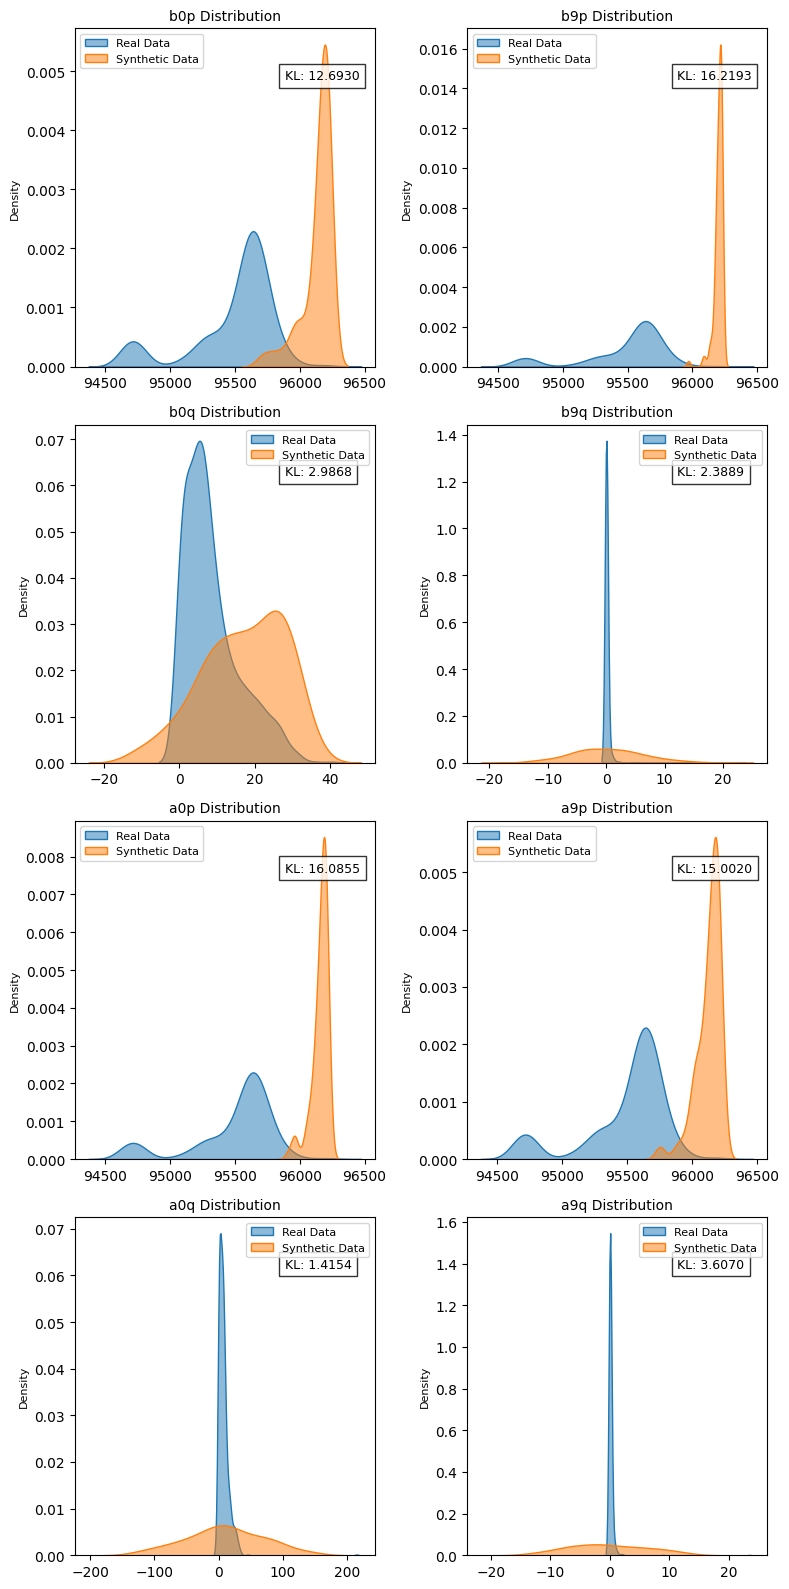

In [14]:
noise = tf.random.normal((100, config.z_dim))
syn_output = trainer.generator.predict(noise)

syn_data = syn_output[0]
syn_data = scaler.inverse_transform(syn_data)
syn_df = pd.DataFrame(syn_data, columns=lob_features)

results = compare_distributions(real_df, syn_df)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


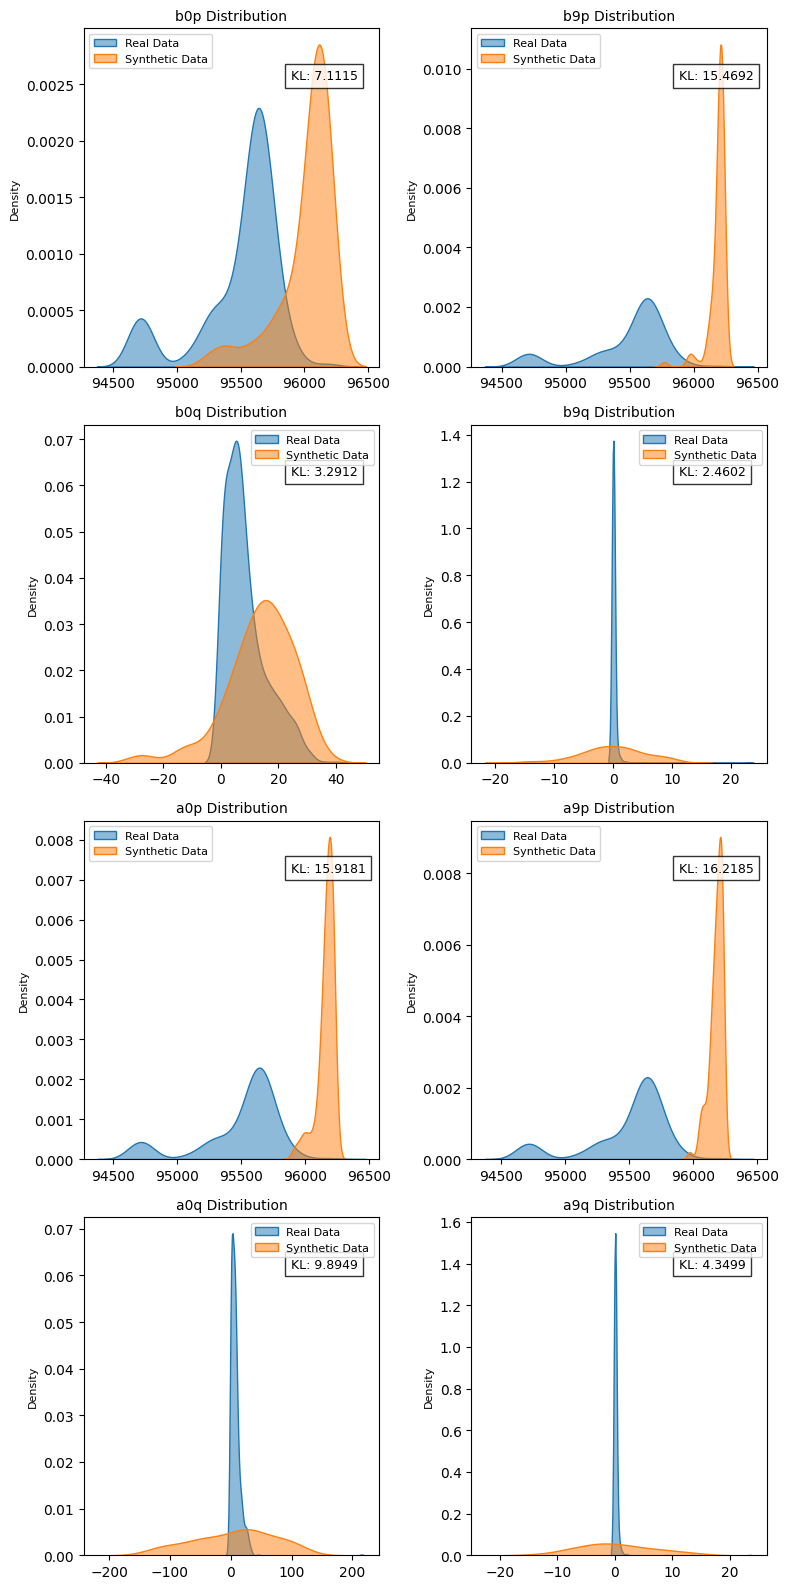

In [15]:
syn_output_ha = trainer_ha.generator.predict(noise)

syn_data_ha = syn_output_ha[0]
syn_data_ha = scaler.inverse_transform(syn_data_ha)
syn_df_ha = pd.DataFrame(syn_data_ha, columns=lob_features)

results_ha = compare_distributions(real_df, syn_df_ha)

1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


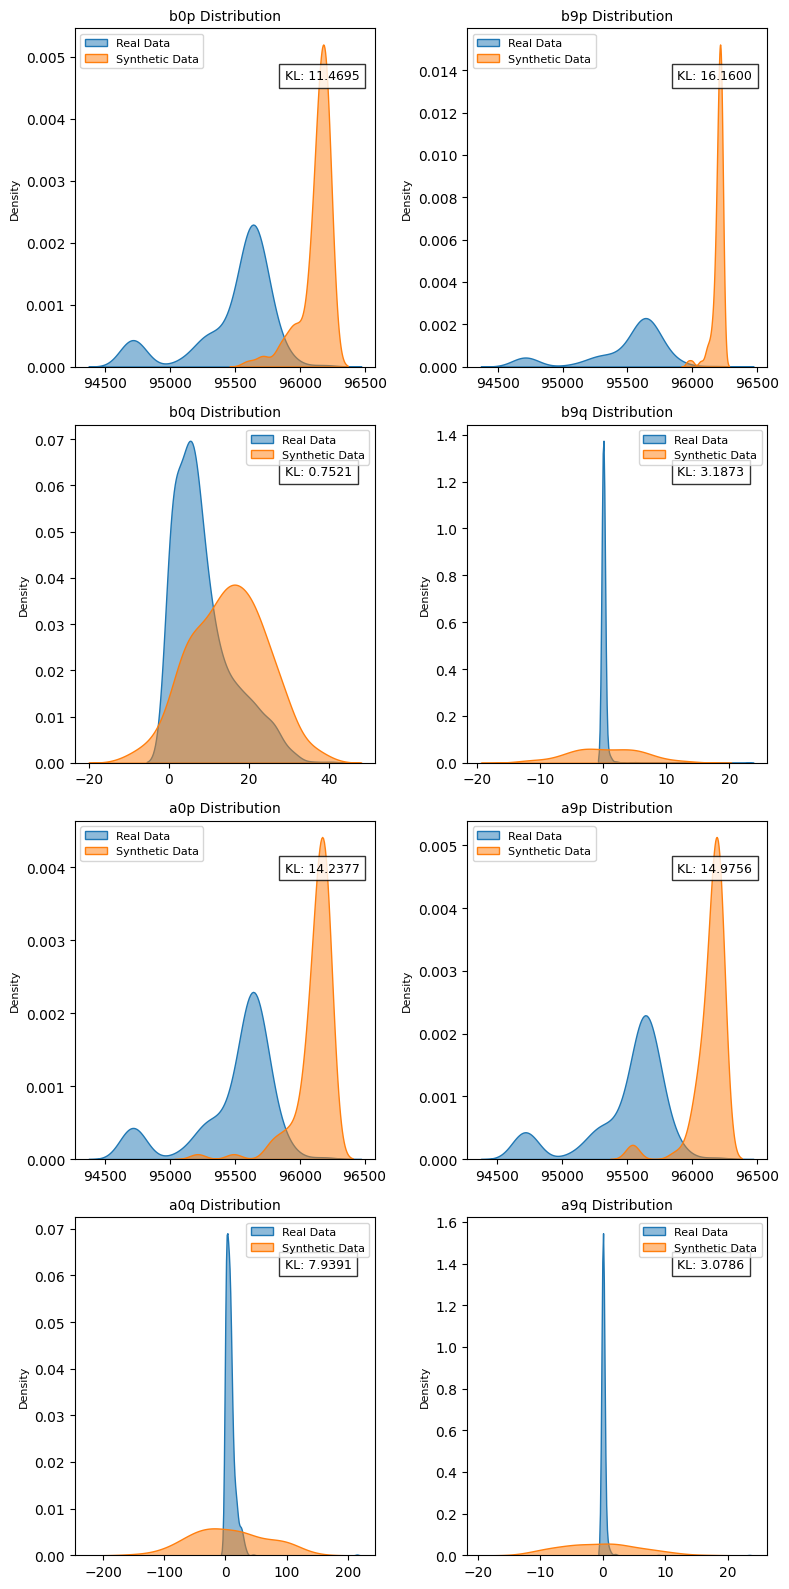

In [16]:
syn_output_ls = trainer_ls.generator.predict(noise)

syn_data_ls = syn_output_ls[0]
syn_data_ls = scaler.inverse_transform(syn_data_ls)
syn_df_ls = pd.DataFrame(syn_data_ls, columns=lob_features)

results_ls = compare_distributions(real_df, syn_df_ls)

In [17]:
# Comparision Output
print(config.name)
print(f"Max KL divergence：{results['max_kl']:.4f}")
print(f"Min KL divergence：{results['min_kl']:.4f}")
print(f"Avg KL divergence：{results['mean_kl']:.4f}")

print(config_ha.name)
print(f"Max KL divergence：{results_ha['max_kl']:.4f}")
print(f"Min KL divergence：{results_ha['min_kl']:.4f}")
print(f"Avg KL divergence：{results_ha['mean_kl']:.4f}")

print(config_ls.name)
print(f"Max KL divergence：{results_ls['max_kl']:.4f}")
print(f"Min KL divergence：{results_ls['min_kl']:.4f}")
print(f"Avg KL divergence：{results_ls['mean_kl']:.4f}")

Baseline
Max KL divergence：22.0179
Min KL divergence：1.4154
Avg KL divergence：9.1242
Historical Averaging
Max KL divergence：16.2469
Min KL divergence：2.3291
Avg KL divergence：9.0721
One-side Label Smoothing
Max KL divergence：16.1880
Min KL divergence：0.7521
Avg KL divergence：7.9653


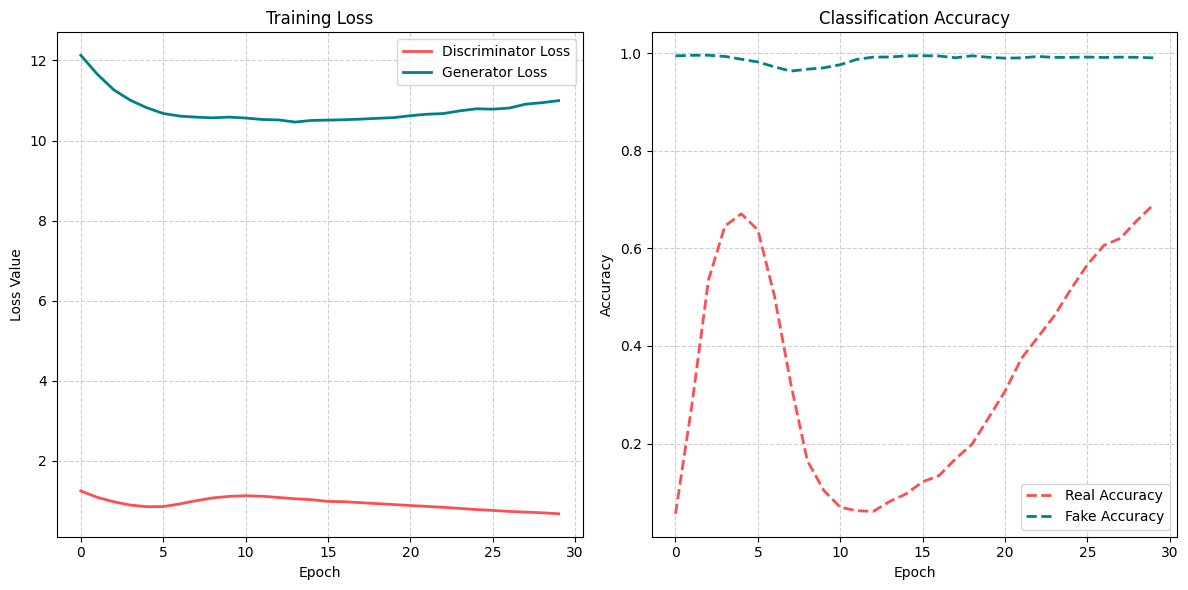

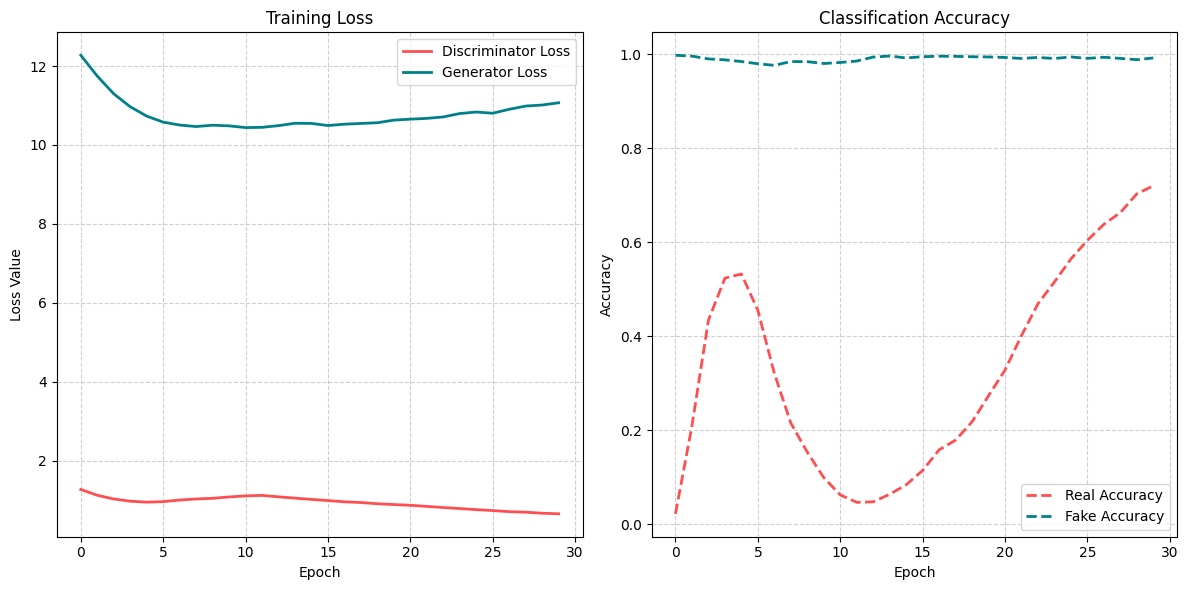

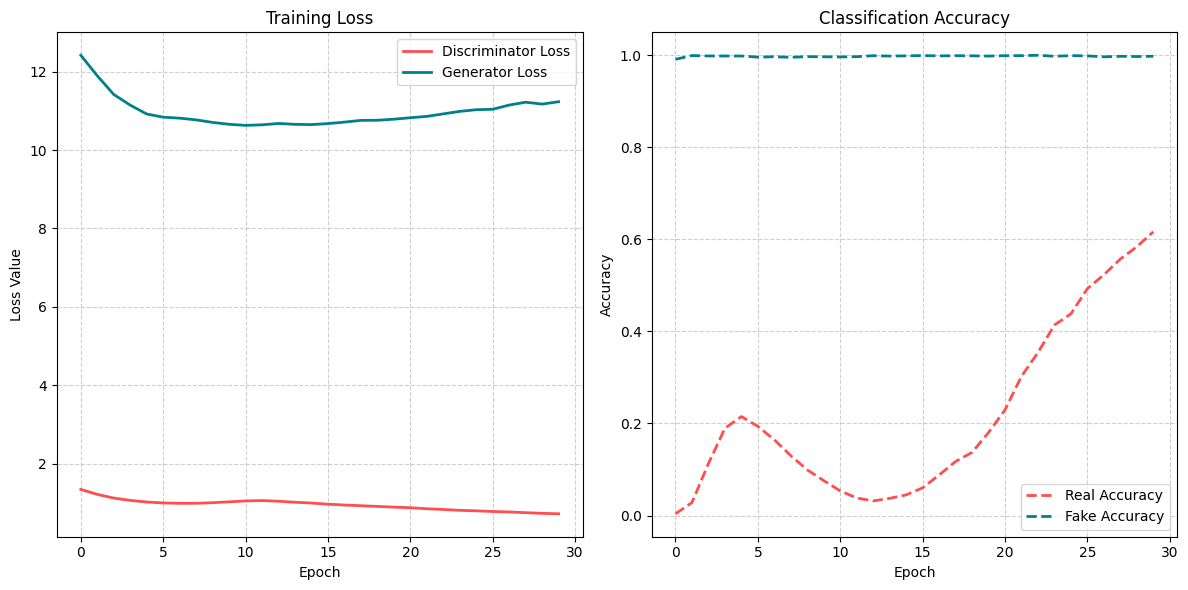

In [18]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    ax1.plot(history['d_loss'], label='Discriminator Loss', color='#FF4E50', linewidth=2)
    ax1.plot(history['g_loss'], label='Generator Loss', color='#00818A', linewidth=2)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss Value')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend()

    ax2.plot(history['real_acc'], label='Real Accuracy', color='#FF4E50', linestyle='--', linewidth=2)
    ax2.plot(history['fake_acc'], label='Fake Accuracy', color='#00818A', linestyle='--', linewidth=2)
    ax2.set_title('Classification Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)
plot_training_history(history_ha)
plot_training_history(history_ls)

In [19]:
def compute_faulty_rate(lob_tensor):
    bid_prices = lob_tensor[:, :10]
    ask_prices = lob_tensor[:, 20:30]
    bid_quantities = lob_tensor[:, 10:20]
    ask_quantities = lob_tensor[:, 30:40]

    faulty_count = tf.reduce_sum(tf.cast(bid_prices[:, 0] >= ask_prices[:, 0], tf.float32))
    faulty_count += tf.reduce_sum(tf.cast(bid_prices[:, :-1] <= bid_prices[:, 1:], tf.float32))
    faulty_count += tf.reduce_sum(tf.cast(ask_prices[:, :-1] >= ask_prices[:, 1:], tf.float32))
    faulty_count += tf.reduce_sum(tf.cast(bid_quantities < 0, tf.float32))
    faulty_count += tf.reduce_sum(tf.cast(ask_quantities < 0, tf.float32))

    total_elements = tf.size(lob_tensor, out_type=tf.float32)
    faulty_rate = faulty_count / total_elements
    return faulty_rate

print("Baseline: Faulty Rate for Synthetic Data:", compute_faulty_rate(syn_data).numpy())
print("Historical Averaging: Faulty Rate for Synthetic Data:", compute_faulty_rate(syn_data_ha).numpy())
print("One-side Label Smoothing: Faulty Rate for Synthetic Data:", compute_faulty_rate(syn_data_ls).numpy())

Baseline: Faulty Rate for Synthetic Data: 0.471
Historical Averaging: Faulty Rate for Synthetic Data: 0.47125
One-side Label Smoothing: Faulty Rate for Synthetic Data: 0.46775
